# SEP Pitch-angle distribution and first-order anisotropies

In [1]:
from anisotropy import run_SEPevent
import datetime as dt
import pandas as pd
import numpy as np
import os

ModuleNotFoundError: No module named 'numba'

In [2]:
# omit some warnings (probably want to put this in the .py file)
from sunpy import log
import warnings

warnings.simplefilter(action='once', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered', category=RuntimeWarning)
warnings.filterwarnings(action='ignore', message='invalid value encountered in divide', category=RuntimeWarning)
log.setLevel('WARNING')

# _ = np.seterr(divide='ignore', invalid='ignore')  # supress some numpy errors
# pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
start_time = pd.to_datetime('2021-10-31 16:00:00')
end_time = pd.to_datetime('2021-11-01 18:00:00')

### Select a local folder to save the downloaded data and output plots

In [4]:
# directory for saving data files
path = os.getcwd()+os.sep+'data'  # '/Users/dresing/data/projects/solo/SOAR' #data path

# directory for saving plots
plot_folder = os.getcwd()+os.sep+'plots'

# directory for saving event objects
# save_folder = os.getcwd()

### Select Spacecraft / Instrument, particle species, and energy channel

In [5]:
spacecraft = "Wind"
instrument = "3DP"
# spacecraft = "STEREO A"
# instrument = "SEPT"
# spacecraft = "Solar Orbiter"
# instrument = "EPT"
# instrument = "HET"
# instrument = "STEP" ???
species = "e"
channels = 3  # no channel averaging implemented for 3DP!
averaging = "2min"  # data averaging

event_id = f'{spacecraft}_{instrument}'  # used for the output plot filenames

### Print available energy channels

In [6]:
# Jan, please add the functions here!

In [7]:
# Jan: Not easily possible, added some output in the following part

# Set data loading and plotting window

Input was Wind, using Wind.
Spacecraft: Wind
Instrument: 3DP. Species: e. Channels: 3.

Available energy channels:
channel
0      18.88 - 35.07 keV
1      28.01 - 52.02 keV
2      46.18 - 85.76 keV
3     75.67 - 140.54 keV
4    126.91 - 235.68 keV
5     216.09 - 401.3 keV
6    360.73 - 669.94 keV
Name: Bins_Text, dtype: string



12-Mar-25 16:18:28: File is current: wind_data/wind_masters/wi_h0_mfi_00000000_v01.cdf
12-Mar-25 16:18:28: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2021/
12-Mar-25 16:18:29: File is current: wind_data/mfi/mfi_h0/2021/wi_h0_mfi_20211031_v05.cdf
12-Mar-25 16:18:30: File is current: wind_data/mfi/mfi_h0/2021/wi_h0_mfi_20211101_v05.cdf


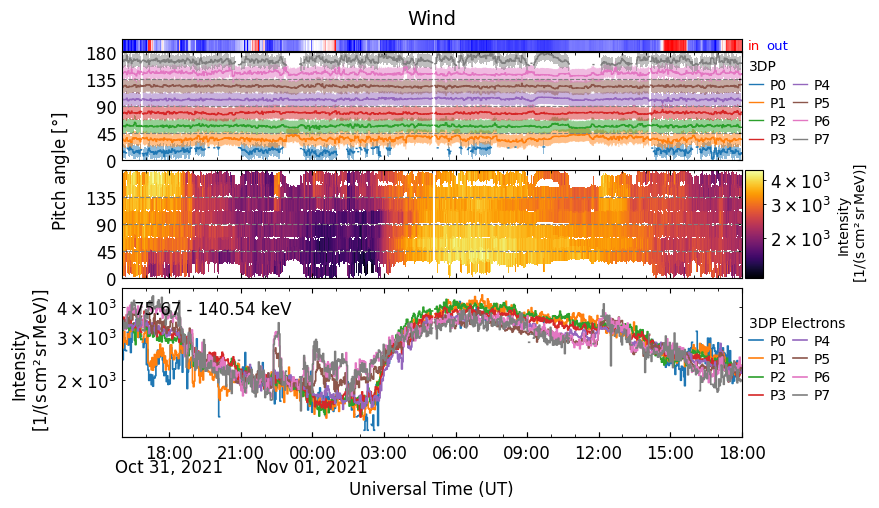

In [8]:
start_time = pd.to_datetime('2021-10-31 16:00:00')
end_time = pd.to_datetime('2021-11-01 18:00:00')

event = run_SEPevent(event_id, path, plot_folder, spacecraft, start_time, end_time, instrument=instrument, species=species, channels=channels, averaging=averaging)
fig, axes = event.overview_plot()

# Background analysis and subtraction
#### Choose a background window!
To determine the (potentially time-dependent) intensity background we fit both, a constant and an exponentially decaying model to the sector-averaged background intensity. We chose the better fit based on the reduded chi-squares. Then the model is extrapolated in time subtracted from the measured intensities.

Background window start: 2021-10-31 23:00:00
Background window end: 2021-11-01 01:30:00
Background correction window end: 2021-11-01 04:30:00
Reduced chi-squared (constant model): 37.90
Reduced chi-squared (exponential model): 37.61
 


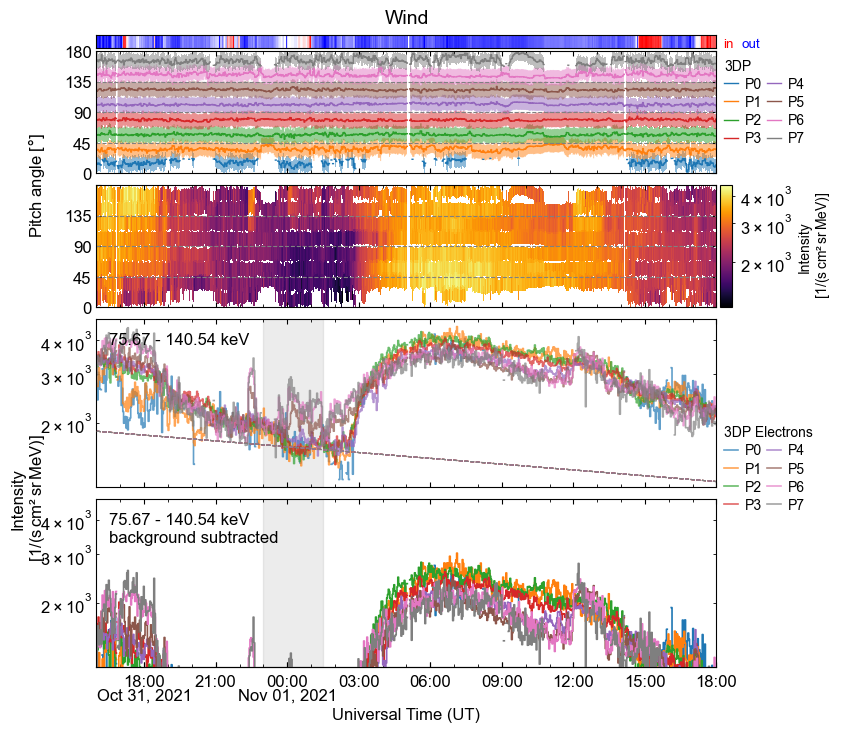

In [9]:
# chose a background window. Leaving these None will set default window [start_time, start_time + 5 hours] 
bg_start = pd.to_datetime('2021-10-31 23:00:00')
bg_end =  pd.to_datetime('2021-11-01 01:30:00')

# chose an end time for the background subtraction:
# if None then background subraction stops 3 hours after the end of the background window (bg_end)
corr_window_end = None #pd.to_datetime('2021-11-01 18:00:00') 

event.set_background_window(bg_start, bg_end, corr_window_end)  # resets background window and event.corr_window_end which is used to check that the background is not above the observations near the event start

bg_av_min = 10  # averaging (in minutes) used only in the background analysis
event.background_analysis_all(minutes=bg_av_min)
fig, axes = event.overview_plot_bgsub()

# Determine Anisotropies

Anisotropies are determined with and without background subtraction. 

### Choose the method for anisotropy calculation: 
- weighted-sum method (strongly suggested for if only 4 viewing directions are available). The weighted-sum method is described in Brüdern et al. 2018, Central European Astrophysical Bulletin, 42, 2.

  
- weighted-sum method including bootstrapping: provides uncertainties for the anisotropy based on bootstrapping within intensity uncertainty ranges

- fit method: pitch-angle distributions are fitted with 2nd-order Legendre Polionomials to determine the anisotropy


Note that anisotropies during noisy low-intensity intervals (like right before the SEP event) cannot be trusted.

!!! No bootstrapping uncertainties available for Wind 3DP due to missing count data
Applying ani_method="weighted_sum" instead


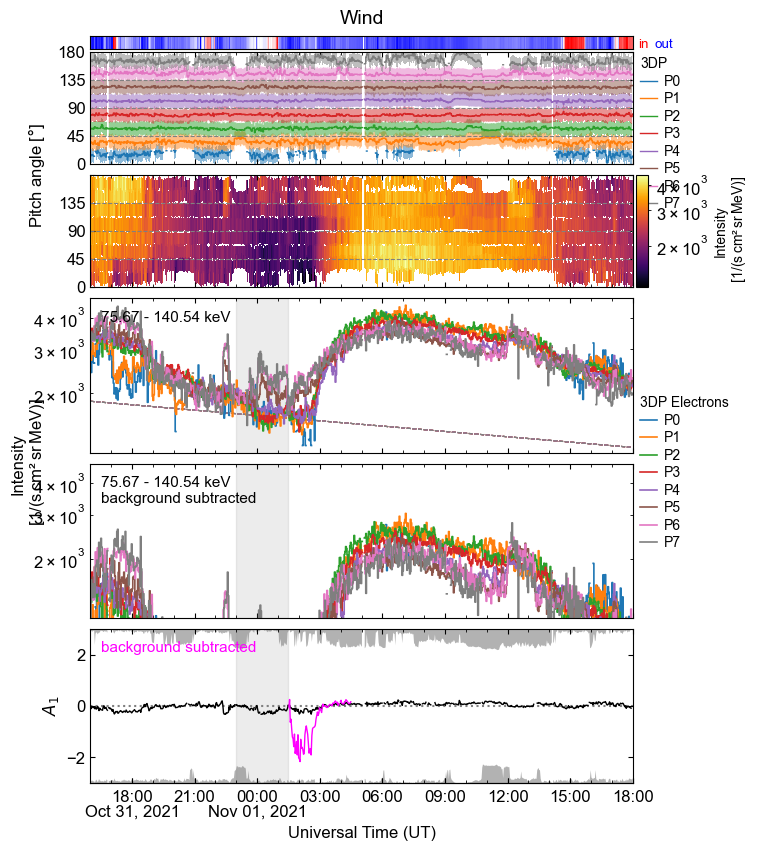

In [10]:
ani_calc_method = 'weighted_sum_bootstrap' # 'weighted_sum', 'weighted_sum_bootstrap', or 'fit'; 'weighted_sum_bootstrap' not available for Wind

event.calculate_anisotropy(ani_method=ani_calc_method)
fig, axes = event.anisotropy_plot(ani_method=ani_calc_method, savefig=True)    

### Plot explanations: 

#### Anisotropy panel:

First order anisotropies without (black) and with (magenta) background subtraction. 
Gray and magenta shades aroung the anisotropy lines show the anisotropy uncertainty based 2.5 and 95 percentiles resulting on a bootstrapping analysis based on counting rate statistics (and the background subtraction - magenta trace) (only shown when ani_method='weighted_sum_bootstrap)'.

Gray shades at the top and bottom of the panel show anisotropy values that cannot be determined with the instrument's pitch-angle coverage at that time.

----------------------
#### Plarity bar at the top of the plot marks the magnetic field polarity:

RED = INWARD, negative polarity, [90, 270] degrees

BLUE = OUTWARD, positive polarity, [270, 360] and [0, 90] degrees